In [1]:
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

In [2]:
h2o_xyz = """3

O    0.000000000000        0.000000000000        0.000000000000
H    0.000000000000        0.740848095288        0.582094932012
H    0.000000000000       -0.740848095288        0.582094932012
"""
molecule = vlx.Molecule.read_xyz_string(h2o_xyz)

In [3]:
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.ostream.mute()
scf_drv.xcfun = "b3lyp"

In [5]:
grid_level = scf_drv.grid_level
if grid_level is None:
    grid_level = vlx.dftutils.get_default_grid_level(scf_drv.xcfun)

grid_drv = vlx.GridDriver()
grid_drv.set_level(grid_level)
molgrid = grid_drv.generate(molecule)

# grid point coordinates
x = molgrid.x_to_numpy()
y = molgrid.y_to_numpy()
z = molgrid.z_to_numpy()

P = molgrid.number_of_points()
print("Number of grid points:", P)

Number of grid points: 40720


In [6]:
grid_xyz = "\nGrid points\n"

r = np.sqrt(x**2 + y**2 + z**2)
au2ang = 0.52911721

i = 0
for p in range(P):
    if r[p] > 5.0:
        grid_xyz += f"He {x[p] * au2ang : 16.8f} {y[p] * au2ang : 16.8f} {z[p] * au2ang : 16.8f}\n"
        i += 1

grid_xyz = str(i) + grid_xyz

print("Number of grid point outside sphere:", i)
print("Number of grid point inside sphere:", P - i)

Number of grid point outside sphere: 5398
Number of grid point inside sphere: 35322


In [7]:
import py3Dmol as p3d

v = p3d.view(width=400, height=400)

v.addModel(h2o_xyz, "xyz")
v.setStyle({"stick": {}})
v.addSurface(p3d.VDW, {"opacity": 0.7, "color": "green"})

v.addModel(grid_xyz, "xyz")
v.setStyle({"elem": "He"}, {"sphere": {"radius": 0.05, "color": "red", "opacity": 0.5}})

v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

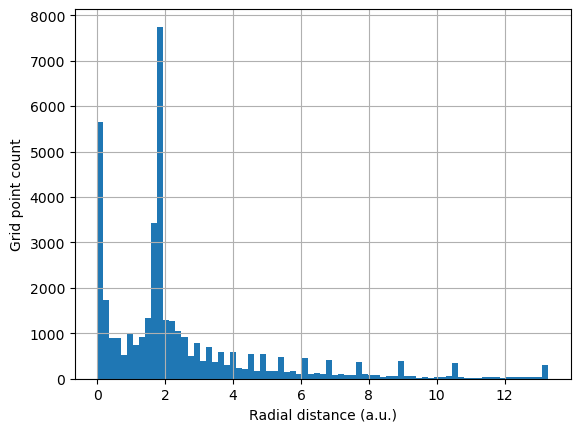

In [8]:
count, rad_dist, patches = plt.hist(r, bins=75)

plt.grid(True)
plt.xlabel("Radial distance (a.u.)")
plt.ylabel("Grid point count")

plt.show()

In [9]:
basis = vlx.MolecularBasis.read(molecule, "def2-svpd", ostream=None)
scf_results = scf_drv.compute(molecule, basis)

D = scf_results["D_alpha"] + scf_results["D_beta"]

In [10]:
xc_drv = vlx.XCIntegrator()

n_grid_points = []
n_elec = []

for grid_level in range(1, 9):
    grid_drv.set_level(grid_level)  # available grid levels are between 1-8

    # generate grid points and weights for molecule
    molgrid = grid_drv.generate(molecule)
    weights = molgrid.w_to_numpy()
    n_grid_points.append(molgrid.number_of_points())

    # generate AOs on the grid points
    chi_g = xc_drv.compute_gto_values(molecule, basis, molgrid)

    # determine the density on the grid points
    G = np.einsum("ab,bg->ag", D, chi_g)
    n_g = np.einsum("ag,ag->g", chi_g, G)
    n_elec.append(np.dot(weights, n_g))

In [11]:
print("Number of grid points:", n_grid_points)

Number of grid points: [4404, 10536, 20678, 40720, 63844, 147024, 348468, 1107906]


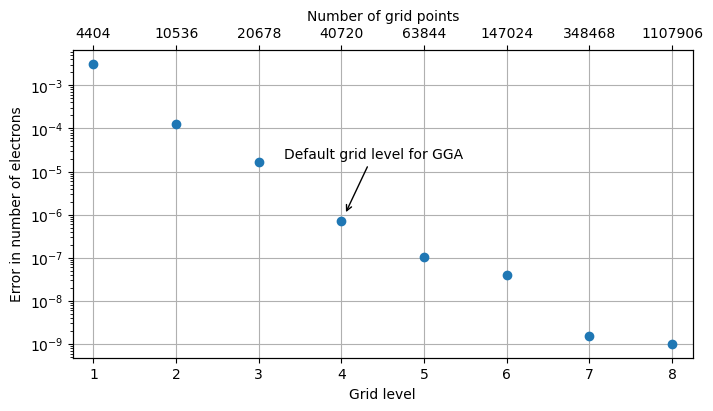

In [12]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(111)

error = abs(np.array(n_elec) - 10)
ax1.plot(range(1, 9), error, "o")

plt.annotate(
    "Default grid level for GGA",
    (4.04, 1e-6),
    xytext=(3.3, 2e-5),
    arrowprops={"arrowstyle": "->"},
)
ax1.set_xlim((0.75, 8.25))

plt.grid()
plt.yscale("log")
plt.xlabel("Grid level")
plt.ylabel("Error in number of electrons")

ax2 = ax1.twiny()
ax2.set_xlim((0.75, 8.25))
ax2.set_xticks(range(1, 9))
ax2.set_xticklabels(n_grid_points)
ax2.set_xlabel("Number of grid points")
plt.show()

In [13]:
grid_drv.set_level(4)  # default level is 4 in VeloxChem

# generate grid points and weights for molecule
molgrid = grid_drv.generate(molecule)
weights = molgrid.w_to_numpy()

In [14]:
n_elec = {}
norb = {}

basis_sets = ["def2-svpd", "aug-cc-pvdz"]
for basis_set in basis_sets:
    basis = vlx.MolecularBasis.read(molecule, basis_set, ostream=None)
    norb[basis_set] = basis.get_dimensions_of_basis()

    # generate AOs on the grid points
    chi_g = xc_drv.compute_gto_values(molecule, basis, molgrid)

    # get the MOs
    scf_results = scf_drv.compute(molecule, basis)  # perform an SCF optimization
    C = scf_results["C_alpha"]  # MO coefficients
    n_elec[basis_set] = []

    for mo in range(norb[basis_set]):
        D = np.einsum("a, b -> ab", C[:, mo], C[:, mo])  # orbital density

        # determine the density on the grid points
        G = np.einsum("ab,bg->ag", D, chi_g)
        n_g = 2 * np.einsum("ag,ag->g", chi_g, G)
        n_elec[basis_set].append(np.dot(weights, n_g))

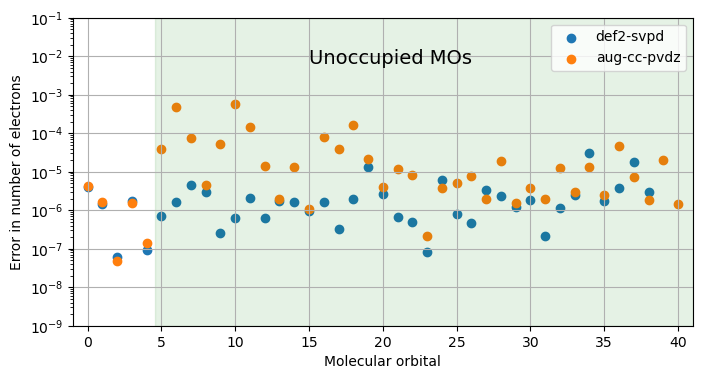

In [15]:
fig = plt.figure(figsize=(8, 4))
ax = plt.axes(xlim=(-1, 41), ylim=(1e-9, 1e-1))

plt.grid(True)
plt.yscale("log")

for basis_set in basis_sets:
    error = abs(np.array(n_elec[basis_set]) - 2)
    plt.scatter(range(norb[basis_set]), error, label=basis_set)

plt.legend()

ax.fill_between(
    [4.6, 41], 0, 1, color="green", alpha=0.1, transform=ax.get_xaxis_transform()
)
ax.text(15, 0.85, "Unoccupied MOs", size=14, transform=ax.get_xaxis_transform())

plt.xlabel("Molecular orbital")
plt.ylabel("Error in number of electrons")

plt.show()